In [1]:
# standard lib imports
import sys
import warnings
from collections import defaultdict

# 3rd party imports
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# external packages in local directory
sys.path.append("../simulate-groups")
from simulate_groups import simulate_ll

# removing warning message when using
warnings.filterwarnings("ignore")

## Simulating data and label graph 

xlabels: Labels


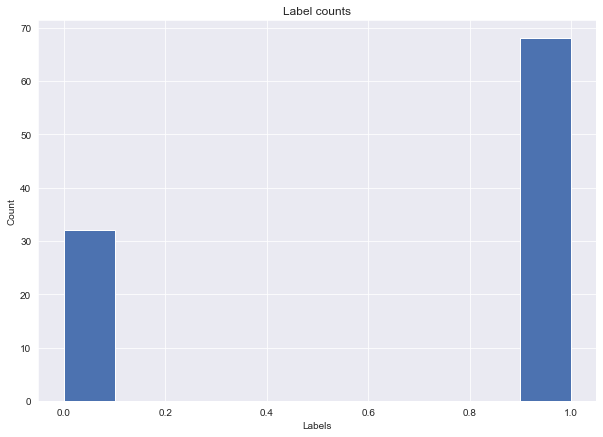

In [17]:
# simulate data 
X, y, info_dict = simulate_ll(n=100, p=20, uncorr_frac=0.1, num_groups=5)

# plotting labels 
ax = plt.subplot()
plt.hist(y)
ax.set_xlabel("Labels")
ax.set_ylabel("Count")
ax.set_title("Label counts")
print("xlabels: {}".format(ax.get_xlabel()))

<AxesSubplot:>

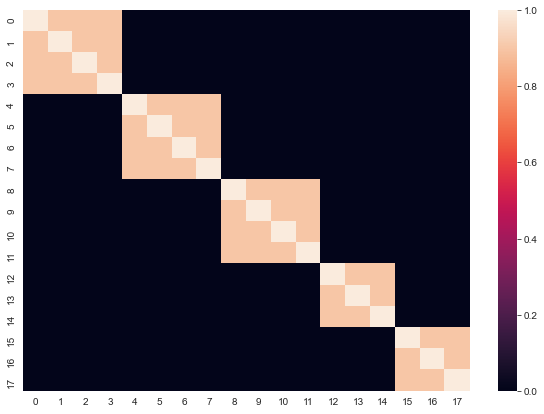

In [18]:
# generated covariance matrix and plotting it 
# -- this is the same shown as the notebook
cov_matrix = info_dict["sigma"]
sns.set({"figure.figsize" : (10, 7)})
sns.heatmap(cov_matrix)

## Creating an ElasticNet Model with generated feature labels and feature scores

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ( 
                             average_precision_score,
                             roc_auc_score)

In [28]:
# Creating a for loop that controls and stores all the model perfromance
l1_ratios = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
random_states_val = [0, 2, 5, 7, 9, 10]

labled_best_models = defaultdict(None)
for random_state in random_states_val:

	# internal labled results
	scores = defaultdict(None)

	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

	# training the model with provided randomness
	model_cv = LogisticRegressionCV(cv=3, penalty="elasticnet", solver="saga", l1_ratios=l1_ratios).fit(X_train, y_train)

	# Testing model with testin set
	y_pred = model_cv.predict(X_test)
	aupr_score = average_precision_score(y_test, y_pred)
	auroc_score = roc_auc_score(y_test, y_pred)

	# compiling scores
	scores["Elastic_model"] = model_cv
	scores["l1_ratio"] = model_cv.l1_ratio_[0]
	scores["Cs_score"] = np.round(model_cv.Cs_, 3)
	scores["AUPR_score"] = round(aupr_score, 3)
	scores["AUROC_score"] = round(auroc_score, 3)

	# storing into main
	labled_best_models["random_state {}".format(random_state)] = scores

In [29]:
# plotting 

defaultdict(None,
            {'random_state 0': defaultdict(None,
                         {'Elastic_model': LogisticRegressionCV(cv=3, l1_ratios=[0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                                               penalty='elasticnet', solver='saga'),
                          'l1_ratio': 0.001,
                          'Cs_score': array([0.00000e+00, 1.00000e-03, 6.00000e-03, 4.60000e-02, 3.59000e-01,
                                 2.78300e+00, 2.15440e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04]),
                          'AUPR_score': 0.763,
                          'AUROC_score': 0.726}),
             'random_state 2': defaultdict(None,
                         {'Elastic_model': LogisticRegressionCV(cv=3, l1_ratios=[0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
                                               penalty='elasticnet', solver='saga'),
                          'l1_ratio': 0.001,
                          'Cs_score': array([0.00000e+00, 1.00000e-03, 